In [0]:
# -*- coding: utf-8 -*-
"""The Copy Task performed by LSTM cells using the tensorflow API"""
__author__ = "Aly Shmahell"
__copyright__ = "Copyright © 2019, Aly Shmahell"
__license__ = "All Rights Reserved"
__version__ = "0.1.2"
__maintainer__ = "Aly Shmahell"
__email__ = "aly.shmahell@gmail.com"
__status__ = "Alpha"

Epoch: 0, Error: 0.6932264566421509, Accuracy: 50.43749809265137
Epoch: 1, Error: 0.6449120044708252, Accuracy: 88.62500190734863
Epoch: 2, Error: 0.5351955890655518, Accuracy: 62.87500262260437
Epoch: 3, Error: 1.5980583429336548, Accuracy: 66.37499928474426
Epoch: 4, Error: 0.24208098649978638, Accuracy: 93.75
Epoch: 5, Error: 0.29699355363845825, Accuracy: 86.62499785423279
Epoch: 6, Error: 0.31071823835372925, Accuracy: 90.12500047683716
Epoch: 7, Error: 0.351706862449646, Accuracy: 77.06249952316284
Epoch: 8, Error: 0.22770042717456818, Accuracy: 98.37499856948853
Epoch: 9, Error: 0.182390496134758, Accuracy: 100.0
Epoch: 10, Error: 0.1549929976463318, Accuracy: 100.0
Epoch: 11, Error: 0.1234765276312828, Accuracy: 100.0
Epoch: 12, Error: 0.09919671714305878, Accuracy: 100.0
Epoch: 13, Error: 0.06473635882139206, Accuracy: 100.0
Epoch: 14, Error: 0.04571192339062691, Accuracy: 100.0
Epoch: 15, Error: 0.027964109554886818, Accuracy: 100.0
Epoch: 16, Error: 0.015336772426962852, Acc

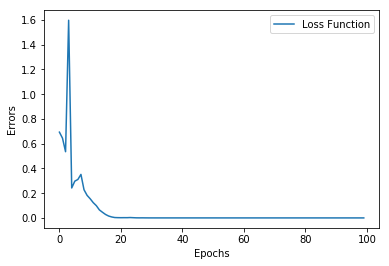

In [35]:
from __future__ import division
from __future__ import print_function
from __future__ import generator_stop 
from __future__ import unicode_literals
from __future__ import absolute_import

import re
import os
import sys
import string
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tensorflow.nn import dynamic_rnn
from tensorflow.nn.rnn_cell import LSTMCell, MultiRNNCell


tf.reset_default_graph()


class Pretty:

    def __new__(self, x):
        return re.sub(r"\n\s*", "\n", x)


class Oneliner:

    def __new__(self, x):
        return re.sub(r"\n\s*", " ", x)


@dataclass()
class Data(object):
  
    corpus: np.array
    symbols_ordered: dict
    symbols_reversed: dict
    corpus_size: int
    symbols_size: int
      
    def __init__(self):
        _text = Oneliner(
                            """long ago , the mice had a general council to consider 
                            what measures they could take to outwit their common enemy ,
                            the cat . 
                            some said this , and some said that but at last a young 
                            mouse got up and said he had a proposal to make , which he 
                            thought would meet the case . 
                            you will all agree , said he , that our chief danger 
                            consists in the sly and treacherous manner 
                            in which the enemy approaches us . 
                            now , if we could receive some signal of her approach , 
                            we could easily escape from her . 
                            I venture , therefore , to propose that a small bell 
                            be procured , and attached by a ribbon round the neck 
                            of the cat . 
                            by this means we should always know when she was about , 
                            and could easily retire while she was in the neighbourhood . 
                            this proposal met with general applause , until an old 
                            mouse got up and said  that is all very well , 
                            but who is to bell the cat ? the mice looked 
                            at one another and nobody spoke . 
                            then the old mouse said it is easy to 
                            propose impossible remedies ."""
                        )
        self.corpus = [
                          word 
                          for i in range(
                                          len(
                                                [
                                                    x.strip() for x in _text
                                                ]
                                             )
                                        ) 
                          for word in [
                                          x.strip() 
                                          for x in _text
                                      ][i].split()
                      ]
        _counter = itertools.count(0)
        self.symbols_ordered = {
                                  chr(i):next(_counter) 
                                  for i in range(128) 
                                  if chr(i) in string.ascii_letters 
                                  or chr(i) in string.digits 
                                  or chr(i) in string.punctuation
                               }
        self.symbols_reversed = dict(
                                        zip(
                                              self.symbols_ordered.values(), 
                                              self.symbols_ordered.keys()
                                           )
                                    )
        self.corpus_size = len(self.corpus)
        self.symbols_size = len(self.symbols_ordered)
        
        
data = Data()


def get_random_chunck(chunk_len):
    if chunk_len > data.corpus_size:
        sys.exit("chunk length exceeds the corpus length")
    _offset = np.random.randint(0, data.corpus_size-chunk_len-1)
    return data.corpus[_offset: _offset+chunk_len]
  
  
def cast_chunk_to_ints(chunk):
    return [
              data.symbols_ordered[c] 
              for c in chunk
           ]

  
def create_batch(num_samples):
    raw = [
              f"{i:>08b}" 
              for i in cast_chunk_to_ints(
                                            get_random_chunck(num_samples)
                                         )
          ]
    np.random.shuffle(raw)
    raw = [
              list(map(int,i)) 
              for i in raw
          ]
    raw = np.array(raw)
    source = np.copy(raw)
    source = source.reshape(num_samples, 8, 1)
    target = np.copy(raw)
    target = target.reshape(num_samples, 8)
    return source, target


def stringify(result):
    return "".join(
                      [
                          data.symbols_reversed[x] 
                          for x in [
                                      int(
                                              "".join(
                                                        [
                                                            str(y) 
                                                            for y in result[i]
                                                        ]
                                                     ),
                                              2
                                          ) 
                                      for i in range(len(result))
                                   ]
                      ]
                  )


class Architecture(object):

    def __init__(self, 
                 units,
                 tf_source_shape,
                 tf_source_dtype,
                 tf_target_shape,
                 tf_target_dtype):
        self.tf_source  = tf.placeholder(
                                          shape=tf_source_shape, 
                                          dtype=tf_source_dtype
                                        )
        self.tf_target  = tf.placeholder(
                                          shape=tf_target_shape, 
                                          dtype=tf_target_dtype
                                        )
        multi_rnn_cells = MultiRNNCell(
                                         [
                                             LSTMCell(
                                                        units, 
                                                        num_proj=len(tf_target_shape)
                                                     ),
                                             LSTMCell(
                                                       units, 
                                                       num_proj=len(tf_target_shape)
                                                     )
                                         ]
                                       )
        self.output, _  = tf.nn.dynamic_rnn(
                                              multi_rnn_cells, 
                                              self.tf_source, 
                                              dtype=tf_source_dtype
                                           )

      
structure = Architecture(
                           units= 64,
                           tf_source_shape = [None, None, 1],
                           tf_source_dtype = tf.float32,
                           tf_target_shape = [None, None],
                           tf_target_dtype = tf.int64
                        )
 

loss_function = tf.reduce_mean(
                                  tf.nn
                                    .sparse_softmax_cross_entropy_with_logits(
                                                                                labels=structure.tf_target, 
                                                                                logits=structure.output
                                                                             )
                              )
optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss_function)


prediction = tf.argmax(structure.output, axis=2)
validity = tf.equal(structure.tf_target, prediction)
precision = tf.reduce_mean(tf.cast(validity, tf.float32))
  
  
errors = []


with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    for epoch in range(100):
        source, target = create_batch(200)
        _, error, accuracy = session.run(
                                            [
                                                optimizer, 
                                                loss_function, 
                                                precision
                                            ],
                                            feed_dict={
                                                        structure.tf_source: source,
                                                        structure.tf_target: target
                                                      }
                                         )
        print(f"Epoch: {epoch}, Error: {error}, Accuracy: {accuracy*100}")
        errors.append(error)
    source = [
                [
                    [0],[1],[0],[0],[0],[1],[1],[1]
                ], 
                [
                    [0],[1],[0],[0],[0],[1],[0],[0]
                ], 
                [
                    [0],[1],[0],[1],[1],[0],[0],[0]
                ]
             ]
    print(
            Oneliner(
                        f"""Source: 
                                    {
                                      stringify(
                                                  np.reshape(
                                                               np.array(source), 
                                                               [3, 8]
                                                            )
                                               )
                                    }
                         """
                    )
         )
    print(
            Oneliner(
                        f"""Predicted: 
                                        {
                                          stringify(
                                                      session.run(
                                                                    prediction,
                                                                    feed_dict={structure.tf_source: source}
                                                                  )
                                                   )
                                        }
                         """
                    )
         )

    
plt.plot(errors,label="Loss Function")
plt.xlabel("Epochs")
plt.ylabel("Errors")
plt.legend()
plt.show()